# Import

In [1]:
import pandas as pd
import numpy as np

from tqdm import tqdm
from collections import defaultdict

from statsmodels.regression.linear_model import OLS
from sklearn.metrics import r2_score, accuracy_score

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
def loadPrices(fn):
    global nt, nInst
    df = pd.read_csv(fn, sep='\s+', header=None, index_col=None)
    (nt, nInst) = df.shape
    return (df.values).T

# Load Data

In [4]:
prcAll = loadPrices('prices2023.txt')

NUM_STOCKS = prcAll.shape[0]

# Build Models

In [5]:
def get_log_returns(prices):
    # get log_returns
    # put into pandas
    prices_df = pd.DataFrame(prices).T
    # turn into log returns
    log_return_df = prices_df.pct_change().apply(lambda x: np.log(1+x)).shift(-1)

    for ma in (5, 10, 20):
        for stock_i in range(nInst+1):
            log_return_df[f'forward_{ma}_{stock_i}'] = np.log(prices_df[stock_i]/prices_df[stock_i].shift(ma)).shift(-ma)
            log_return_df[f'close_to_close (t-{ma})(t0)_'+str(stock_i)] = np.log(prices_df[stock_i]/prices_df[stock_i].shift(ma))

    return log_return_df

In [6]:
def feature_engineer(prices):
    
    # add market which is the mean of all returns
    prices = np.vstack((prices, prices.mean(axis=0)))

    log_return_df = get_log_returns(prices)
    # feature engineering

    for stock_id in range(nInst+1):
        # create lag1
        log_return_df['lag1_'+str(stock_id)] = log_return_df[stock_id].shift(1)
        # create lag2
        log_return_df['lag2_'+str(stock_id)] = log_return_df[stock_id].shift(2)
        # create lag3
        log_return_df['lag3_'+str(stock_id)] = log_return_df[stock_id].shift(3)
        # create lag4
        log_return_df['lag4_'+str(stock_id)] = log_return_df[stock_id].shift(4)

        # create MA
        log_return_df['ma5_'+str(stock_id)] = log_return_df[stock_id].rolling(window=5).mean().shift(1)
        log_return_df['ma10_'+str(stock_id)] = log_return_df[stock_id].rolling(window=10).mean().shift(1)
        log_return_df['ma20_'+str(stock_id)] = log_return_df[stock_id].rolling(window=20).mean().shift(1)
        
    
    return log_return_df

In [7]:
log_return_df = feature_engineer(prcAll)

In [8]:
TRAIN_LENGTH = 250
TEST_LENGTH = 50
FIRST_TEST_DATE = 250

features = ['ma5']
target_column = 'forward_5'

TREND = False

In [9]:
# todo: class this

def build_univariate_linear_regression(log_return_df, target_stock, feature_stock, features, test_start_date, train_length, trend):

    data = log_return_df[[target_stock]+[f'{_}_{feature_stock}' for _ in features]].iloc[test_start_date-train_length:test_start_date]
    data.dropna(inplace=True)

    try:
        y = data[target_column+str(target_stock)]
    except:
        y = data[target_stock]
    X = data.drop(target_stock, axis=1)
    X = X.assign(const=1)

    if trend:
        X = X.assign(trend=np.arange(len(X)))
        
    # build models
    model = OLS(y, X).fit()

    return model

def inference_univariate_linear_regression(log_return_df, model, target_stock, feature_stock, features, test_start_date, train_length, trend):
    
    X = log_return_df[[f'{_}_{feature_stock}' for _ in features]].iloc[-1:]

    X = X.assign(const=1)

    if trend:
        X = X.assign(trend=len(log_return_df)-test_start_date+train_length)
    
    pred_t1 = model.predict(X).values[0]

    return pred_t1

def predict_train_univariate(log_return_df, model, target_stock, feature_stock, features, test_start_date, train_length, trend):
    
    data = log_return_df[[target_stock]+[f'{_}_{feature_stock}' for _ in features]].iloc[test_start_date-train_length:test_start_date]
    data.dropna(inplace=True)

    y = data[target_stock]
    X = data.drop(target_stock, axis=1)
    X = X.assign(const=1)

    if trend:
        X = X.assign(trend=np.arange(len(X))) # add trend

    y_pred = model.predict(X)
    
    return y, y_pred

In [10]:
def build_multivariate_linear_regression(log_return_df, target_stock, feature_stock, features, test_start_date, train_length, trend):

    data = log_return_df[[target_stock]+[f'{_}_{target_stock}' for _ in features]+[f'{_}_{feature_stock}' for _ in features]].iloc[test_start_date-train_length:test_start_date]
    data.dropna(inplace=True)

    try:
        y = data[target_column+str(target_stock)]
    except:
        y = data[target_stock]
    X = data.drop(target_stock, axis=1)
    X = X.assign(const=1)

    if trend:
        X = X.assign(trend=np.arange(len(X))) 
        
    # build models
    model = OLS(y, X).fit()

    return model

def inference_multivariate_linear_regression(log_return_df, model, target_stock, feature_stock, features, test_start_date, train_length, trend):
    
    X = log_return_df[[f'{_}_{target_stock}' for _ in features]+[f'{_}_{feature_stock}' for _ in features]].iloc[-1:]

    X = X.assign(const=1)

    if trend:
        X = X.assign(trend=len(log_return_df)-test_start_date+train_length)
    
    pred_t1 = model.predict(X).values[0]

    return pred_t1

def predict_train_multivariate(log_return_df, model, target_stock, feature_stock, features, test_start_date, train_length, trend):
    
    data = log_return_df[[target_stock]+[f'{_}_{target_stock}' for _ in features]+[f'{_}_{feature_stock}' for _ in features]].iloc[test_start_date-train_length:test_start_date]
    data.dropna(inplace=True)

    y = data[target_stock]
    X = data.drop(target_stock, axis=1)
    X = X.assign(const=1)

    if trend:
        X = X.assign(trend=np.arange(len(X)))

    y_pred = model.predict(X)
    
    return y, y_pred

In [11]:
# good_model_dict = defaultdict(dict)
# model_accuracy_dict = defaultdict(dict)
# model_features_dict = defaultdict(dict)

# for i in tqdm(range(NUM_STOCKS+1)):
#     for j in range(NUM_STOCKS+1):

#         ma_model = build_univariate_linear_regression(log_return_df, i, j, features, FIRST_TEST_DATE, TRAIN_LENGTH, False)
#         ma_y, ma_pred = predict_train_univariate(log_return_df, ma_model, i, j, features, FIRST_TEST_DATE, TRAIN_LENGTH, False)

#         trend_features = [feature for feature in features if 'ma' not in feature]
#         trend_model = build_univariate_linear_regression(log_return_df, i, j, trend_features, FIRST_TEST_DATE, TRAIN_LENGTH, True)
#         trend_y, trend_pred = predict_train_univariate(log_return_df, trend_model, i, j, trend_features, FIRST_TEST_DATE, TRAIN_LENGTH, True)

#         if abs(ma_model.tvalues.values[0]) >= 2:
#             if abs(trend_model.tvalues.values[0]) >= 2:
#                 if accuracy_score(np.sign(ma_y), np.sign(ma_pred)) >= accuracy_score(np.sign(trend_y), np.sign(trend_pred)):
#                     good_model_dict[i][j] = ma_model
#                     model_features_dict[i][j] = [features, False]
#                     model_accuracy_dict[i][j] = accuracy_score(np.sign(ma_y), np.sign(ma_pred))
#                 else:
#                     good_model_dict[i][j] = trend_model
#                     model_features_dict[i][j] = [trend_features, True]
#                     model_accuracy_dict[i][j] = accuracy_score(np.sign(trend_y), np.sign(trend_pred))
#             else:
#                 good_model_dict[i][j] = ma_model
#                 model_features_dict[i][j] = [features, False]
#                 model_accuracy_dict[i][j] = accuracy_score(np.sign(ma_y), np.sign(ma_pred))
#         elif abs(trend_model.tvalues.values[0]) >= 2:
#             good_model_dict[i][j] = trend_model
#             model_features_dict[i][j] = [trend_features, True]
#             model_accuracy_dict[i][j] = accuracy_score(np.sign(trend_y), np.sign(trend_pred))

# final_model = defaultdict(dict)

# for stock_i in model_accuracy_dict:
#     top_10 = sorted(model_accuracy_dict[stock_i].items(), key=lambda x: x[1], reverse=True)[:10]
#     for stock_j, score in top_10:
#         if score <= 0.5: # we don't want models that are not even accurate in training data
#             continue # TODO: maybe use r2 to get top 10, and accuracy to further filter out?

#         if stock_j in good_model_dict[stock_i]: # Todo: in future take average, or take average of votes?
#             final_model[stock_i][stock_j] = good_model_dict[stock_i][stock_j]

In [12]:
# good_model_dict = defaultdict(dict)
# model_accuracy_dict = defaultdict(dict)
# model_features_dict = defaultdict(dict)

# for i in tqdm(range(NUM_STOCKS+1)):
#     for j in range(NUM_STOCKS+1):

#         if i == j:
#             continue

#         ma_model = build_multivariate_linear_regression(log_return_df, i, j, features, FIRST_TEST_DATE, TRAIN_LENGTH, False)
#         ma_y, ma_pred = predict_train_multivariate(log_return_df, ma_model, i, j, features, FIRST_TEST_DATE, TRAIN_LENGTH, False)

#         trend_features = [feature for feature in features if 'ma' not in feature]
#         trend_model = build_multivariate_linear_regression(log_return_df, i, j, trend_features, FIRST_TEST_DATE, TRAIN_LENGTH, True)
#         trend_y, trend_pred = predict_train_multivariate(log_return_df, trend_model, i, j, trend_features, FIRST_TEST_DATE, TRAIN_LENGTH, True)

#         if abs(ma_model.tvalues.values[0]) >= 2 or abs(ma_model.tvalues.values[len(features)]//2) >= 2:
#             if abs(trend_model.tvalues.values[0]) >= 2 or abs(trend_model.tvalues.values[len(trend_features)]//2) >= 2:
#                 if accuracy_score(np.sign(ma_y), np.sign(ma_pred)) >= accuracy_score(np.sign(trend_y), np.sign(trend_pred)):
#                     good_model_dict[i][j] = ma_model
#                     model_features_dict[i][j] = [features, False]
#                     model_accuracy_dict[i][j] = accuracy_score(np.sign(ma_y), np.sign(ma_pred))
#                 else:
#                     good_model_dict[i][j] = trend_model
#                     model_features_dict[i][j] = [trend_features, True]
#                     model_accuracy_dict[i][j] = accuracy_score(np.sign(trend_y), np.sign(trend_pred))
#             else:
#                 good_model_dict[i][j] = ma_model
#                 model_features_dict[i][j] = [features, False]
#                 model_accuracy_dict[i][j] = accuracy_score(np.sign(ma_y), np.sign(ma_pred))
#         elif abs(trend_model.tvalues.values[0]) >= 2 or abs(trend_model.tvalues.values[len(trend_features)]//2) >= 2:
#             good_model_dict[i][j] = trend_model
#             model_features_dict[i][j] = [trend_features, True]
#             model_accuracy_dict[i][j] = accuracy_score(np.sign(trend_y), np.sign(trend_pred))

# final_model = defaultdict(dict)

# for stock_i in model_accuracy_dict:
#     top_10 = sorted(model_accuracy_dict[stock_i].items(), key=lambda x: x[1], reverse=True)[:10]
#     for stock_j, score in top_10:
#         if score <= 0.5: # we don't want models that are not even accurate in training data
#             continue # TODO: maybe use r2 to get top 10, and accuracy to further filter out?

#         if stock_j in good_model_dict[stock_i]: # Todo: in future take average, or take average of votes?
#             final_model[stock_i][stock_j] = good_model_dict[stock_i][stock_j]

In [13]:
# for i in model_accuracy_dict:
#     print(i, final_model[i].keys())

# Backtest

## Define Strategy

In [14]:
def build_models_for_this_period(log_return_df, first_start_date):

    good_model_dict = defaultdict(dict)
    model_accuracy_dict = defaultdict(dict)
    model_features_dict = defaultdict(dict)

    for i in range(NUM_STOCKS):
        for j in range(NUM_STOCKS+1):

            ma_model = build_univariate_linear_regression(log_return_df, i, j, features, first_start_date, TRAIN_LENGTH, False)
            ma_y, ma_pred = predict_train_univariate(log_return_df, ma_model, i, j, features, first_start_date, TRAIN_LENGTH, False)

            trend_features = [feature for feature in features if 'ma' not in feature]
            trend_model = build_univariate_linear_regression(log_return_df, i, j, trend_features, first_start_date, TRAIN_LENGTH, True)
            trend_y, trend_pred = predict_train_univariate(log_return_df, trend_model, i, j, trend_features, first_start_date, TRAIN_LENGTH, True)

            if abs(ma_model.tvalues.values[0]) >= 2 and abs(ma_model.tvalues['const']) < 2:
                good_model_dict[i][j] = ma_model
                model_features_dict[i][j] = [features, False]
                model_accuracy_dict[i][j] = accuracy_score(np.sign(ma_y), np.sign(ma_pred))
            #     if abs(trend_model.tvalues.values[0]) >= 2:
            #         if accuracy_score(np.sign(ma_y), np.sign(ma_pred)) >= accuracy_score(np.sign(trend_y), np.sign(trend_pred)):
            #             good_model_dict[i][j] = ma_model
            #             model_features_dict[i][j] = [features, False]
            #             model_accuracy_dict[i][j] = accuracy_score(np.sign(ma_y), np.sign(ma_pred))
            #         else:
            #             good_model_dict[i][j] = trend_model
            #             model_features_dict[i][j] = [trend_features, True]
            #             model_accuracy_dict[i][j] = accuracy_score(np.sign(trend_y), np.sign(trend_pred))
            #     else:
            #         good_model_dict[i][j] = ma_model
            #         model_features_dict[i][j] = [features, False]
            #         model_accuracy_dict[i][j] = accuracy_score(np.sign(ma_y), np.sign(ma_pred))
            # elif abs(trend_model.tvalues.values[0]) >= 2:
            #     good_model_dict[i][j] = trend_model
            #     model_features_dict[i][j] = [trend_features, True]
            #     model_accuracy_dict[i][j] = accuracy_score(np.sign(trend_y), np.sign(trend_pred))

    final_model_dict = defaultdict(dict)

    for stock_i in model_accuracy_dict:
        top_10 = sorted(model_accuracy_dict[stock_i].items(), key=lambda x: x[1], reverse=True)[:10]
        for stock_j, score in top_10:
            if score <= 0.5: # we don't want models that are not even accurate in training data
                continue # TODO: maybe use r2 to get top 10, and accuracy to further filter out?

            if stock_j in good_model_dict[stock_i]: # Todo: in future take average, or take average of votes?
                final_model_dict[stock_i][stock_j] = good_model_dict[stock_i][stock_j]

    return final_model_dict, model_features_dict

In [15]:
def getMyPosition(prcSoFar):
    
    global currentPos, final_model_dict, old_model_dict, model_features_dict, first_start_date
    
    if prcSoFar.shape[1] == 500: # last day don't make any new positions
        return currentPos

    log_return_df = feature_engineer(prcSoFar)

    # retrain model every 50 days
    if prcSoFar.shape[1] % TEST_LENGTH == 0:
        first_start_date = prcSoFar.shape[1]

        final_model_dict, model_features_dict = build_models_for_this_period(log_return_df, first_start_date)

    #     if prcSoFar.shape[1] != 250: # TODO: hardcoded restore no-trade positions to 0
    #         for stock_i in old_model_dict:
    #             if stock_i not in final_model_dict:
    #                 currentPos[stock_i] = 0
    
    # old_model_dict = final_model_dict
        
    # make predictions
    for stock_i in final_model_dict:
        stock_i_predictions_list = []
        for stock_j in final_model_dict[stock_i]:
            stock_i_predictions_list.append(inference_univariate_linear_regression(log_return_df,
                                       final_model_dict[stock_i][stock_j],
                                       stock_i,
                                       stock_j,
                                       model_features_dict[stock_i][stock_j][0],
                                       first_start_date,
                                       TRAIN_LENGTH,
                                       model_features_dict[stock_i][stock_j][1]))
        stock_i_prediction = np.mean(stock_i_predictions_list)

        signals[stock_i, prcSoFar.shape[1]-250] = stock_i_prediction

        if stock_i_prediction >= 0.0000:
            currentPos[stock_i] += 1000/prcSoFar[stock_i, -1]
        elif stock_i_prediction < -0.0000:
            currentPos[stock_i] -= 1000/prcSoFar[stock_i, -1]

    return currentPos

## Run

In [16]:
signals = np.zeros([50, 251])
positions = np.zeros([50, 251])
returns = np.zeros([50, 251])

values_array = np.zeros([50, 251])
cash_array = np.zeros([50, 251])
todayPL_array = np.zeros([50, 251])

commRate = 0.0010
dlrPosLimit = 10000

nInst = 50
currentPos = np.zeros(nInst)

def calcPL(prcHist):
    global pll
    cash = 0
    curPos = np.zeros(nInst)
    totDVolume = 0
    totDVolumeSignal = 0
    totDVolumeRandom = 0
    value = 0
    todayPLL = []
    (_, nt) = prcHist.shape
    for t in range(250, 501): # t will go from 250 to 500 (251 numbers)
        prcHistSoFar = prcHist[:, :t] # t=250 => will go from i.e. day 0 to day 249 (250 days). day = t-1; t = 500: don't trade - only lose brockerage
        newPosOrig = getMyPosition(prcHistSoFar) # day 250 train, then make positions for 251...
        curPrices = prcHistSoFar[:, -1]
        posLimits = np.array([int(x) for x in dlrPosLimit / curPrices])
        newPos = np.clip(newPosOrig, -posLimits, posLimits) # t0 make new positions
        deltaPos = newPos - curPos # t0 change position
        
        positions[:, prcHistSoFar.shape[1]-250] = newPos # record position
        
        dvolumes = curPrices * np.abs(deltaPos) # t0 transaction volumes
        dvolume = np.sum(dvolumes)
        totDVolume += dvolume 
        comm = dvolume * commRate # t0 commission
        cash -= curPrices.dot(deltaPos) + comm  # t0 change in cash: long/short stocks and commission

        cash_array[:, prcHistSoFar.shape[1]-250] = np.zeros([50]) - curPrices * deltaPos - np.abs(deltaPos) * curPrices * commRate if t == 250 \
              else cash_array[:, prcHistSoFar.shape[1]-250-1] - curPrices * deltaPos - np.abs(deltaPos) * curPrices * commRate

        curPos = np.array(newPos) 
        posValue = curPos.dot(curPrices) # value of stocks = what was earned from t-1's positions + value of t0 stocks. (balances out part of the cash change)
        todayPL = cash + posValue - value # today's profit/loss: cash + value of stocks - value of stocks at t-1 
        
        if t != 500:
            returns[:, prcHistSoFar.shape[1]-250] = prcHist[:, t] / prcHist[:, t-1] - 1
            todayPL_array[:, prcHistSoFar.shape[1]-250] = cash_array[:, prcHistSoFar.shape[1]-250] + curPos * curPrices if t == 250 \
                else cash_array[:, prcHistSoFar.shape[1]-250] + curPos * curPrices - values_array[:, prcHistSoFar.shape[1]-250-1]

        todayPLL.append(todayPL) 
        value = cash + posValue

        values_array[:, prcHistSoFar.shape[1]-250] = cash_array[:, prcHistSoFar.shape[1]-250] + curPos * curPrices

        ret = 0.0
        if (totDVolume > 0):
            ret = value / totDVolume
        print("Day %d value: %.2lf todayPL: $%.2lf $-traded: %.0lf return: %.5lf" %
              (t, value, todayPL, totDVolume, ret))
    pll = np.array(todayPLL)
    (plmu, plstd) = (np.mean(pll), np.std(pll))
    annSharpe = 0.0
    if (plstd > 0):
        annSharpe = np.sqrt(250) * plmu / plstd
    return (plmu, ret, plstd, annSharpe, totDVolume)


(meanpl, ret, plstd, sharpe, dvol) = calcPL(prcAll)
score = meanpl - 0.1*plstd
print("=====")
print("mean(PL): %.1lf" % meanpl)
print("return: %.5lf" % ret)
print("StdDev(PL): %.2lf" % plstd)
print("annSharpe(PL): %.2lf " % sharpe)
print("totDvolume: %.0lf " % dvol)
print("Score: %.2lf" % score)

Day 250 value: -40.00 todayPL: $-40.00 $-traded: 40000 return: -0.00100
Day 251 value: -84.58 todayPL: $-44.58 $-traded: 80000 return: -0.00106
Day 252 value: -176.00 todayPL: $-91.42 $-traded: 120000 return: -0.00147
Day 253 value: -178.32 todayPL: $-2.32 $-traded: 160000 return: -0.00111
Day 254 value: -259.27 todayPL: $-80.95 $-traded: 200000 return: -0.00130
Day 255 value: -518.48 todayPL: $-259.20 $-traded: 240000 return: -0.00216
Day 256 value: -339.80 todayPL: $178.68 $-traded: 280000 return: -0.00121
Day 257 value: -204.13 todayPL: $135.67 $-traded: 320000 return: -0.00064
Day 258 value: -277.24 todayPL: $-73.12 $-traded: 360000 return: -0.00077
Day 259 value: -206.20 todayPL: $71.05 $-traded: 399622 return: -0.00052
Day 260 value: -86.85 todayPL: $119.35 $-traded: 426483 return: -0.00020
Day 261 value: -80.62 todayPL: $6.23 $-traded: 452977 return: -0.00018
Day 262 value: -215.72 todayPL: $-135.10 $-traded: 477536 return: -0.00045
Day 263 value: -199.30 todayPL: $16.42 $-trade

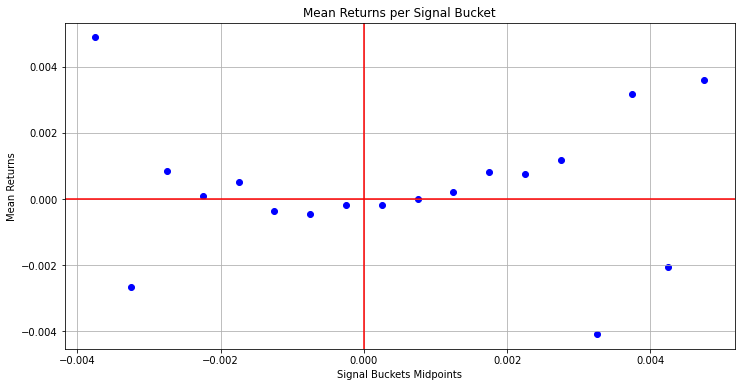

In [17]:
import matplotlib.pyplot as plt

returns_flatten = returns[:250].flatten()
signals_flatten = signals[:250].flatten()

buckets = {}
for i in range(-10, 11):
    buckets[(i/2000, (i+1)/2000)] = [returns_flatten[j] for j in range(len(returns_flatten)) if signals_flatten[j] >= i/2000 and signals_flatten[j] < (i+1)/2000]
buckets = [(key, np.mean(value)) for key, value in buckets.items()]

# Extract the mid-point of each bucket range and the mean returns
bucket_midpoints = [(key[0] + key[1]) / 2 for key, value in buckets]
bucket_means = [value for key, value in buckets]

# Plotting
plt.figure(figsize=(12, 6))
plt.scatter(bucket_midpoints, bucket_means, color='blue')
plt.xlabel('Signal Buckets Midpoints')
plt.ylabel('Mean Returns')
plt.axvline(x=0, color='r', linestyle='-')
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Mean Returns per Signal Bucket')
plt.grid(True)
plt.show()

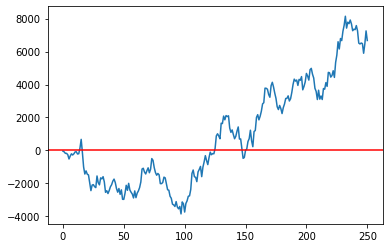

In [18]:
plt.plot(np.cumsum(pll))
plt.axhline(y=0, color='r', linestyle='-')

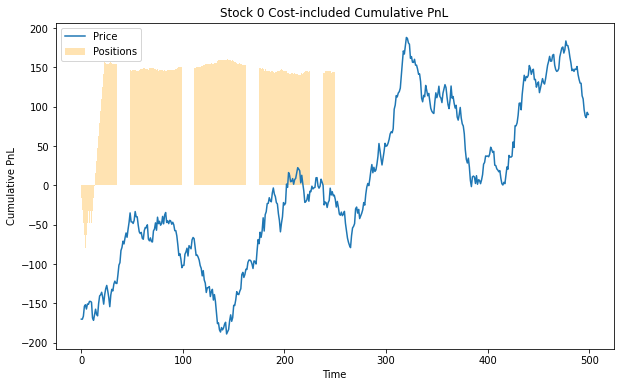

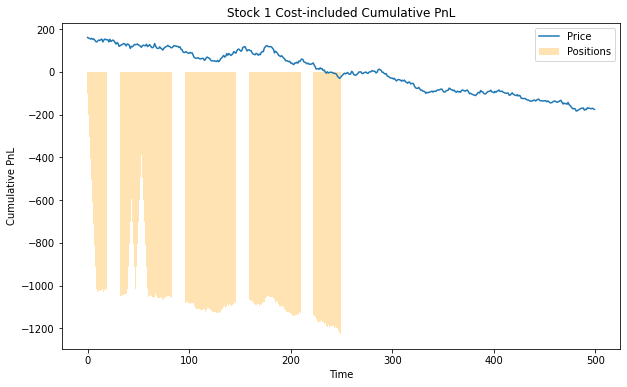

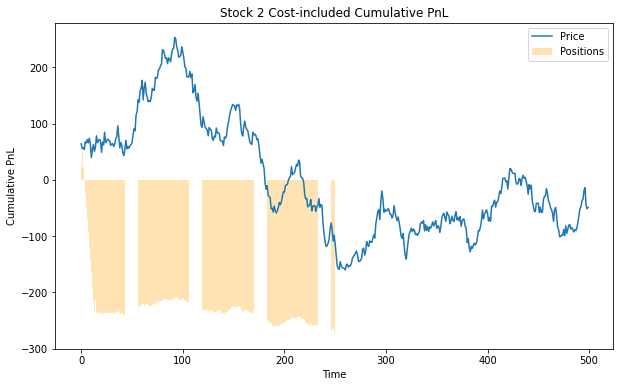

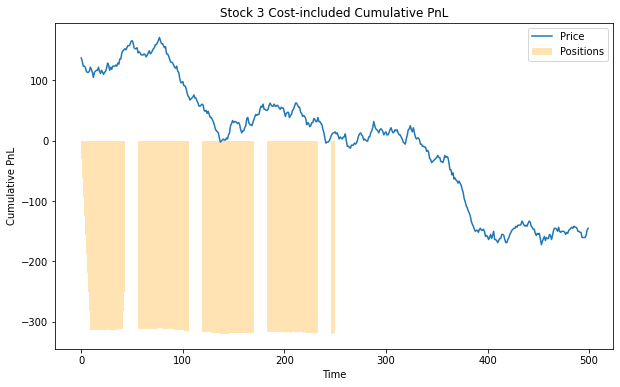

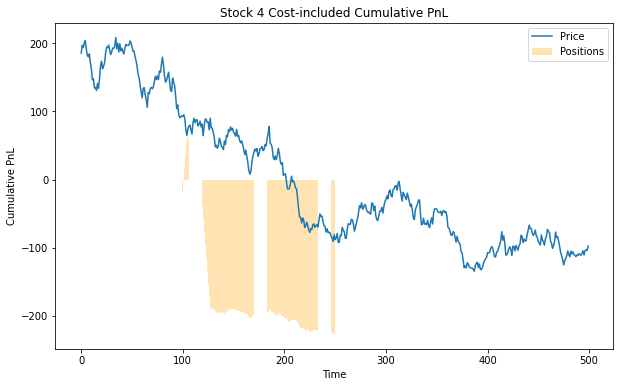

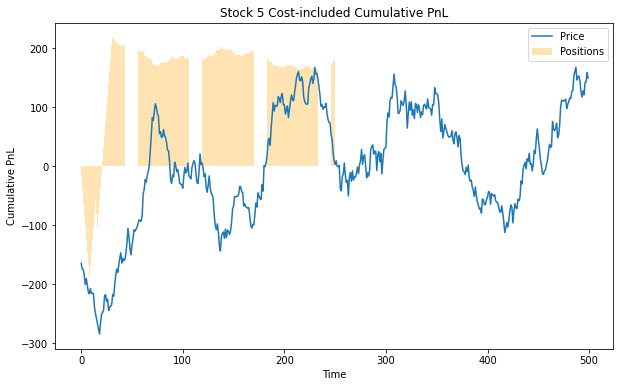

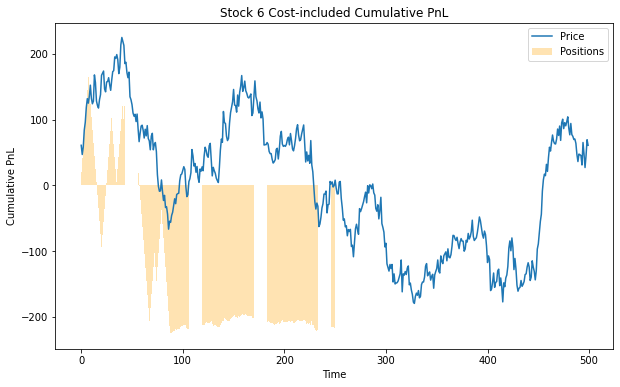

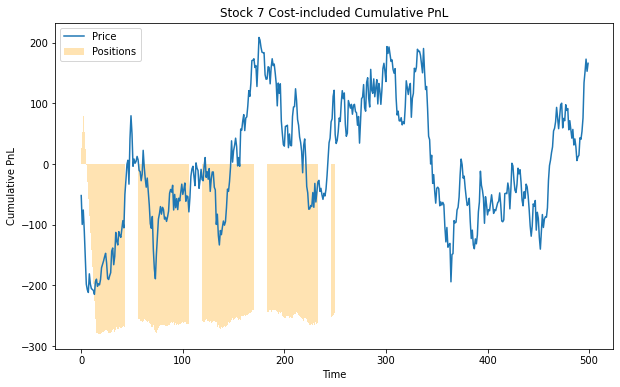

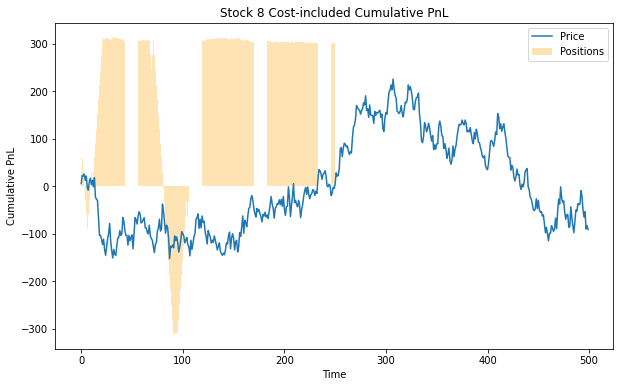

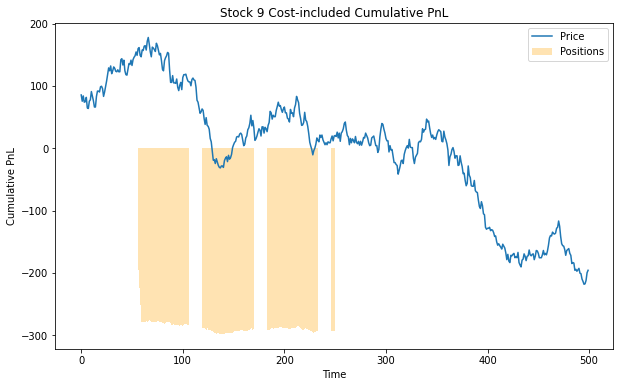

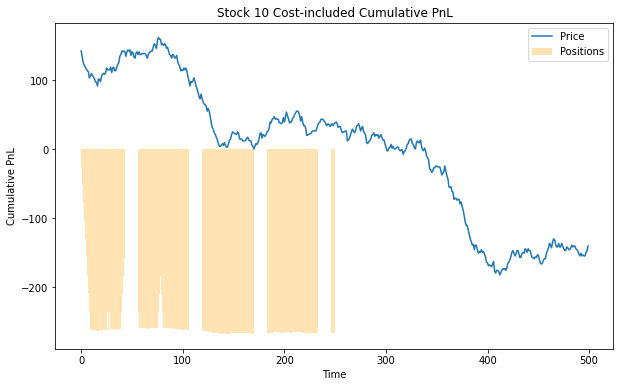

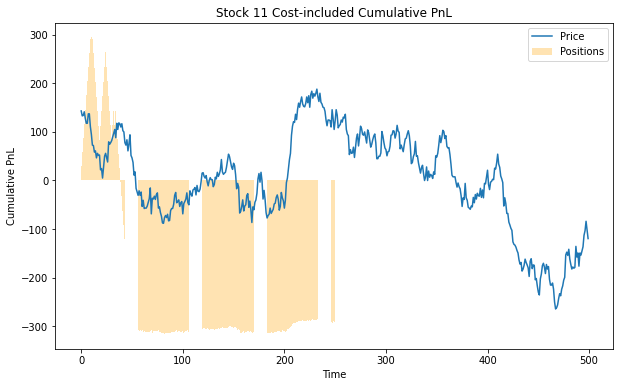

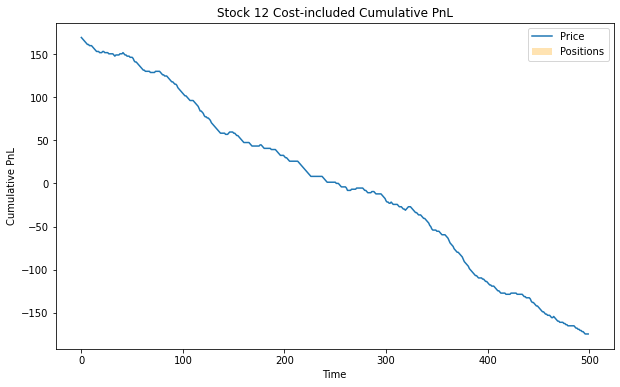

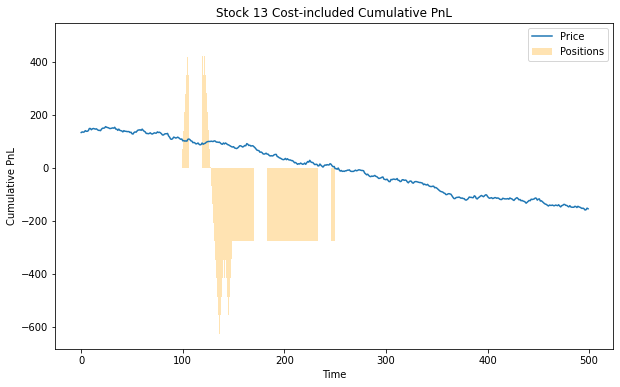

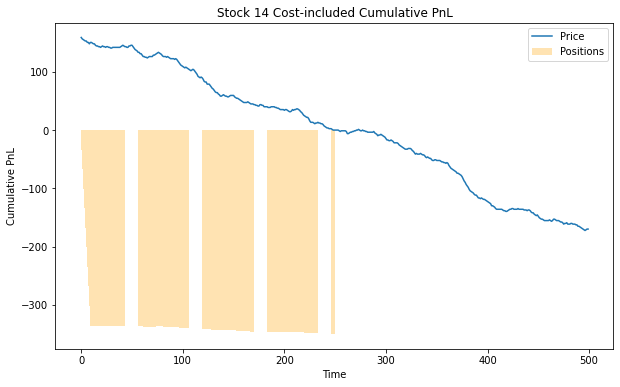

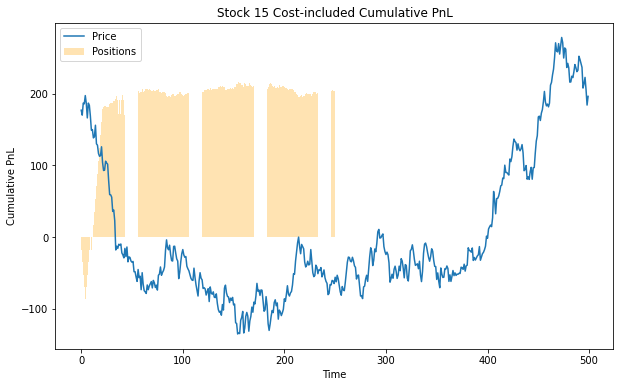

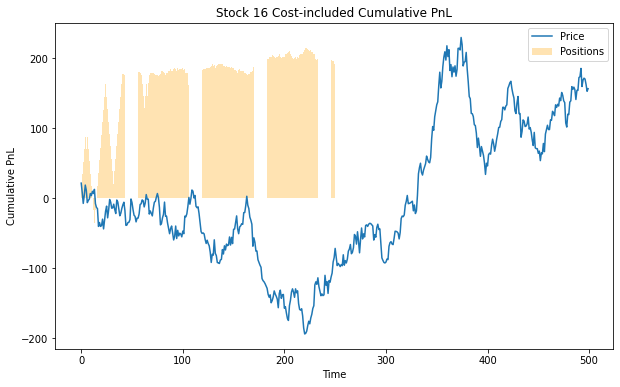

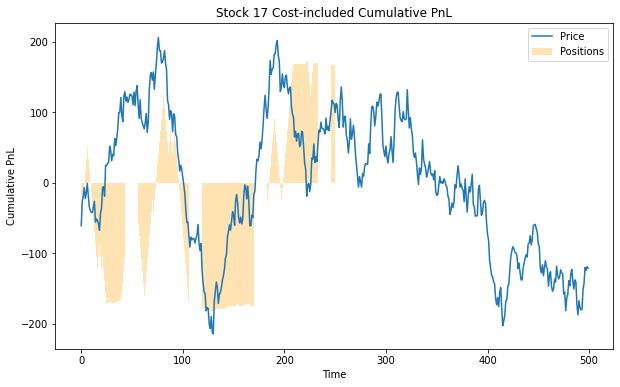

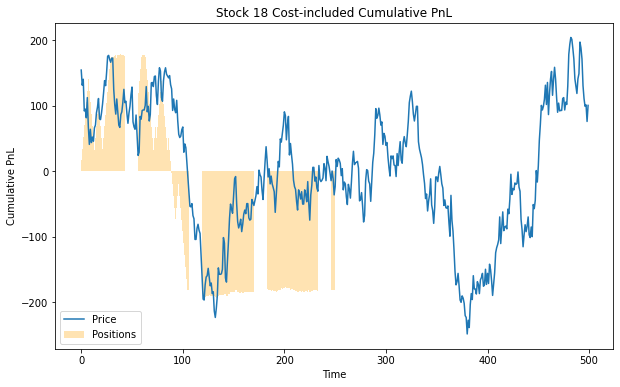

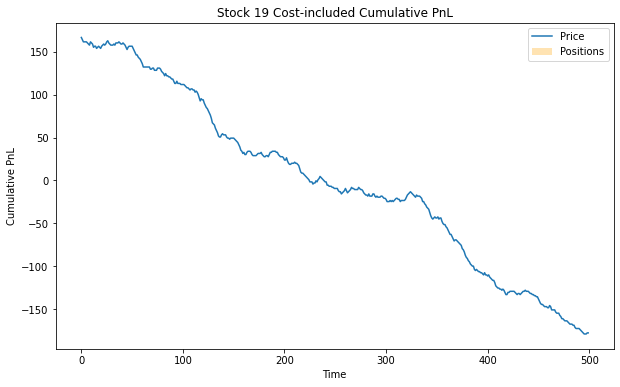

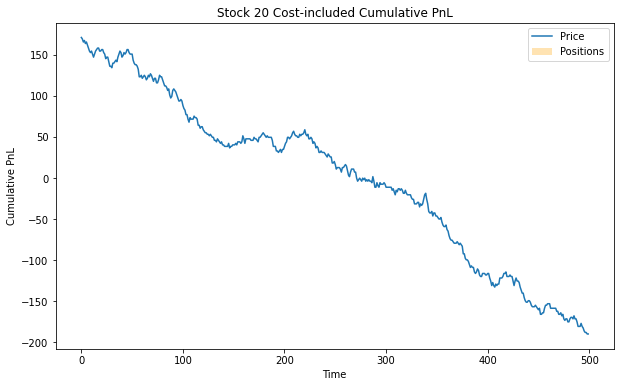

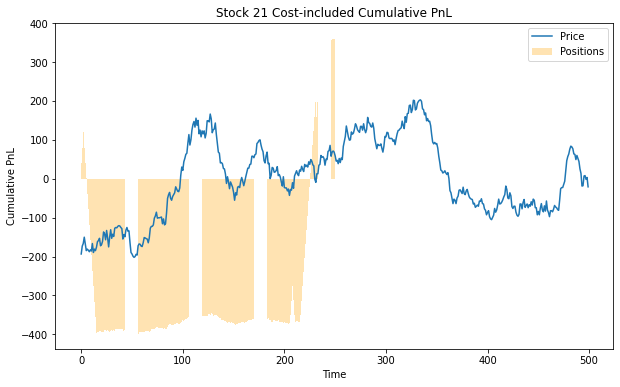

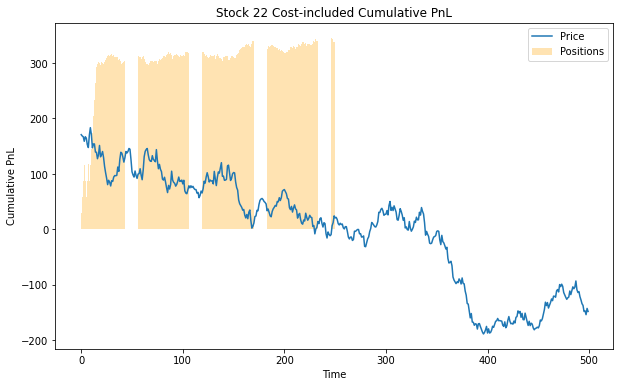

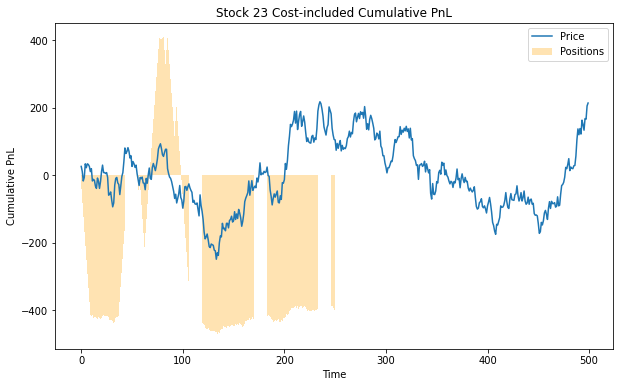

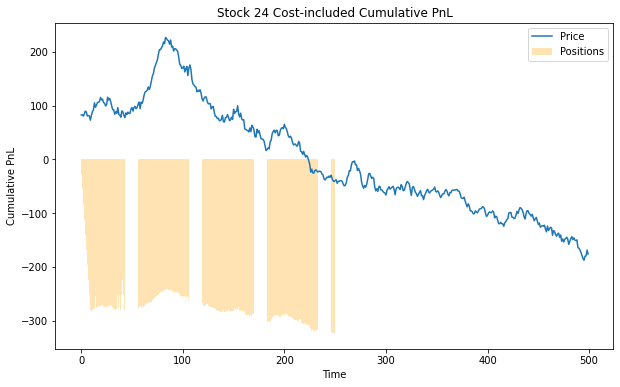

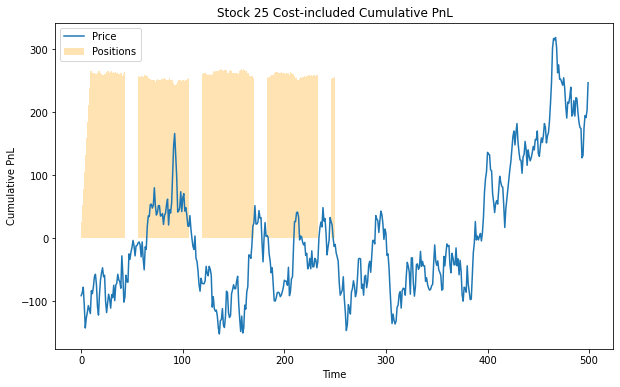

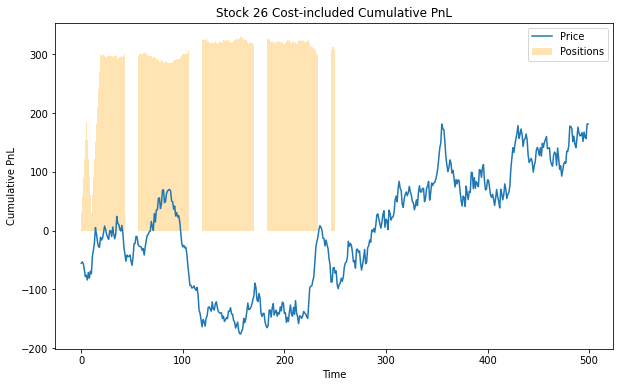

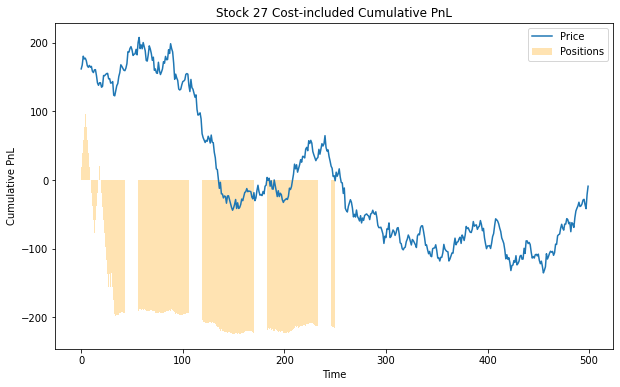

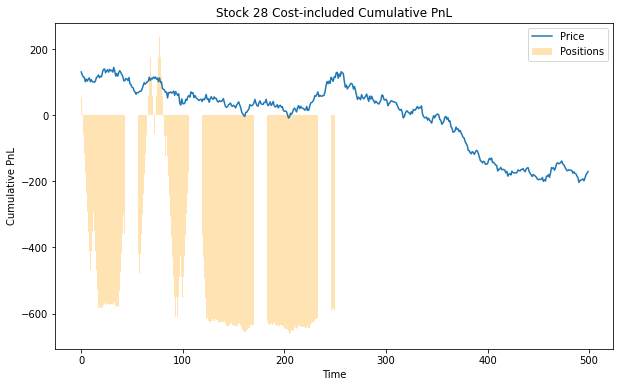

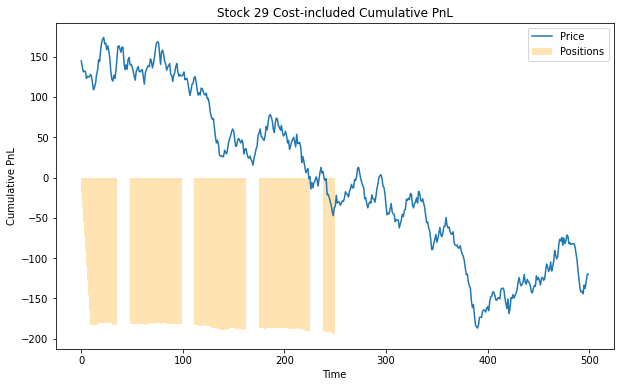

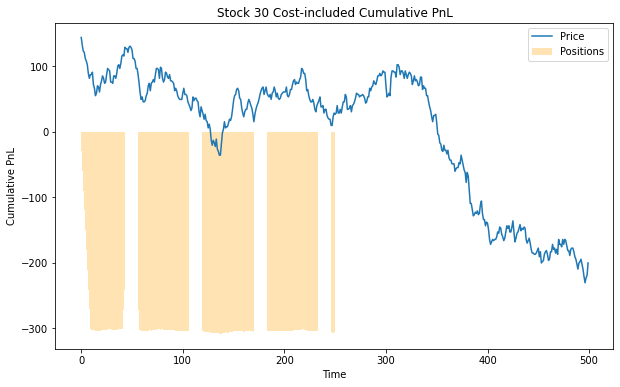

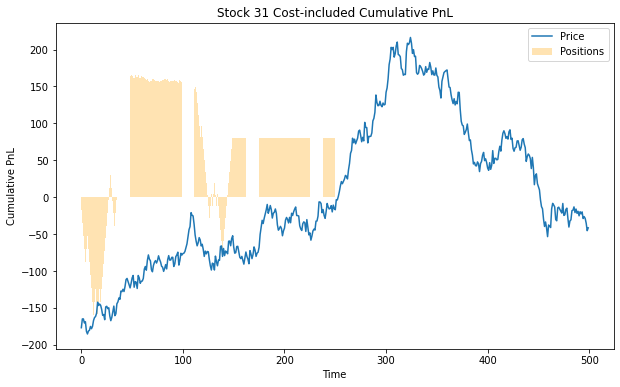

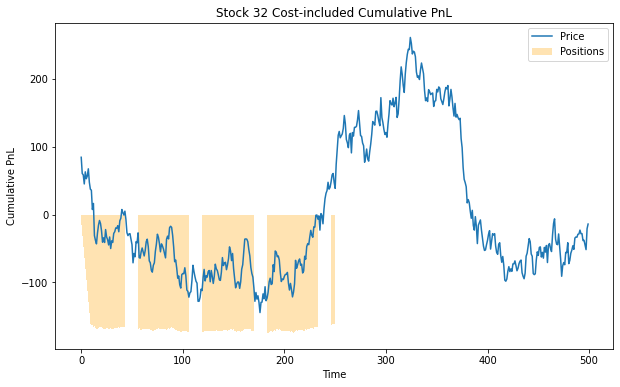

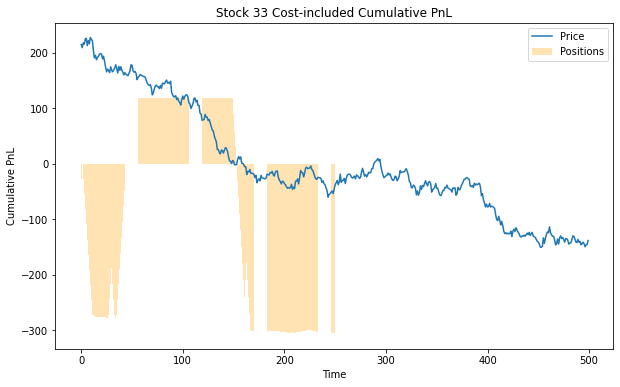

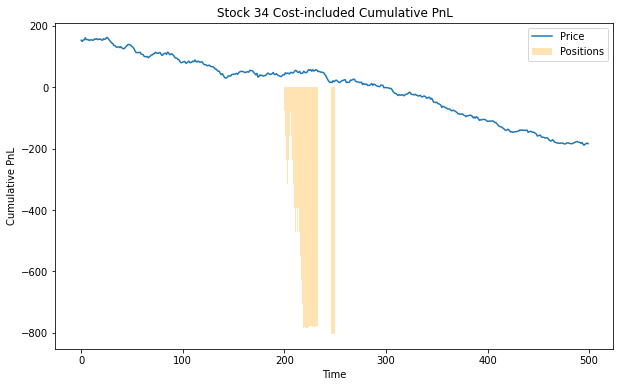

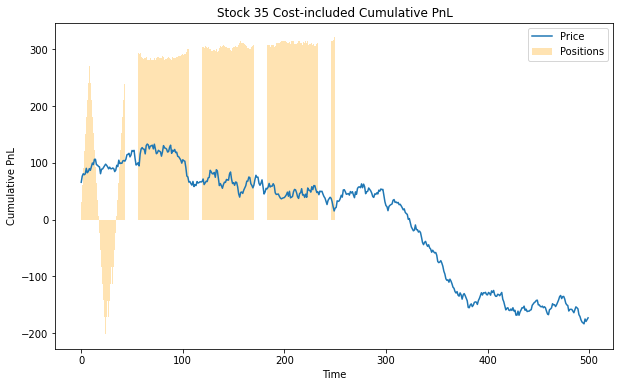

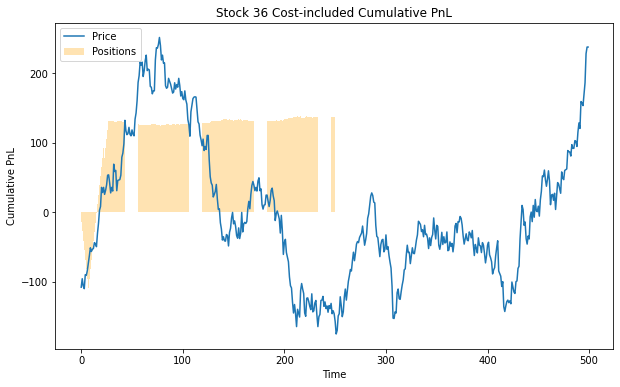

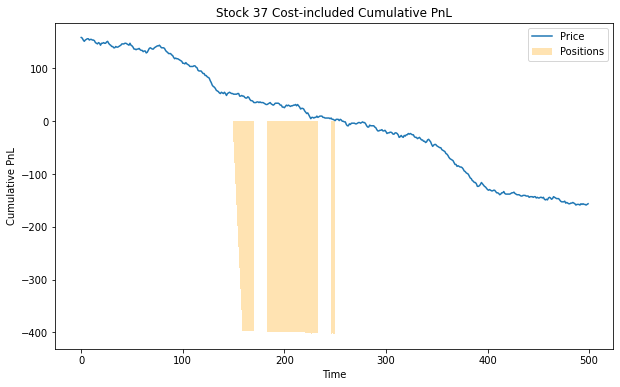

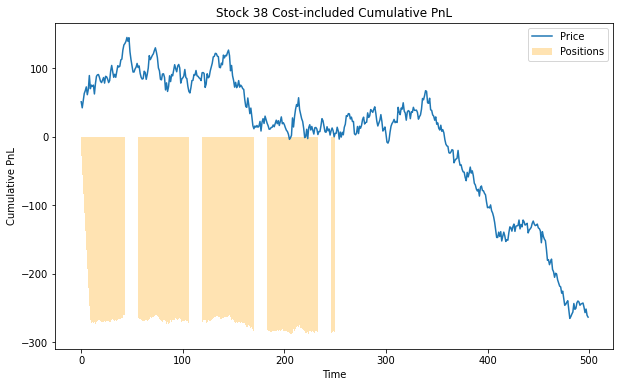

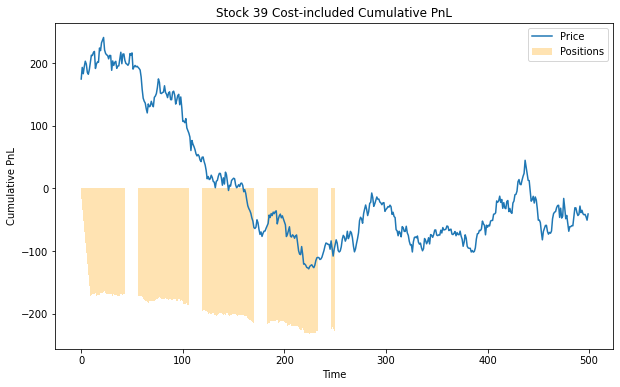

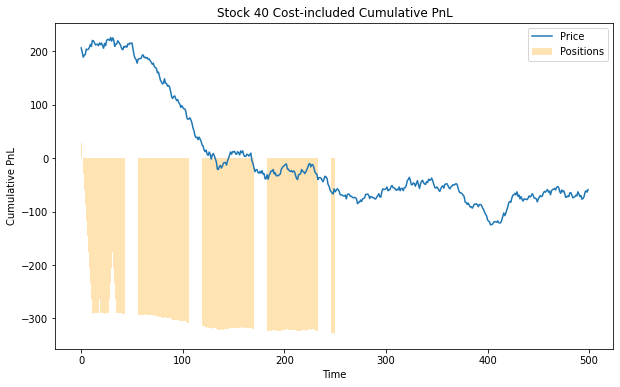

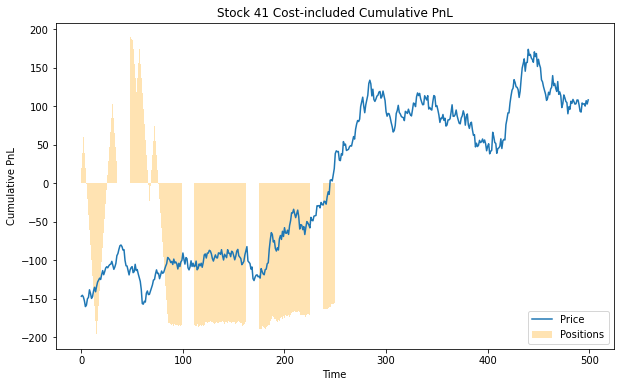

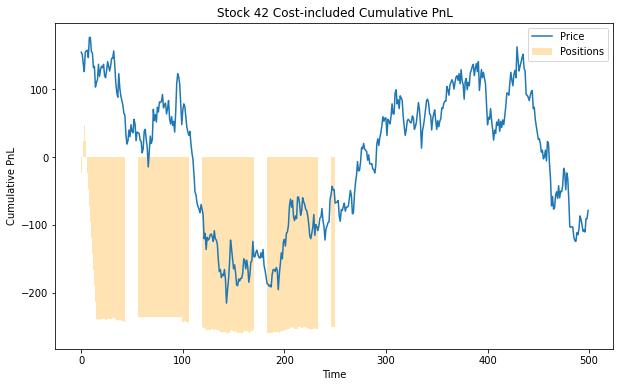

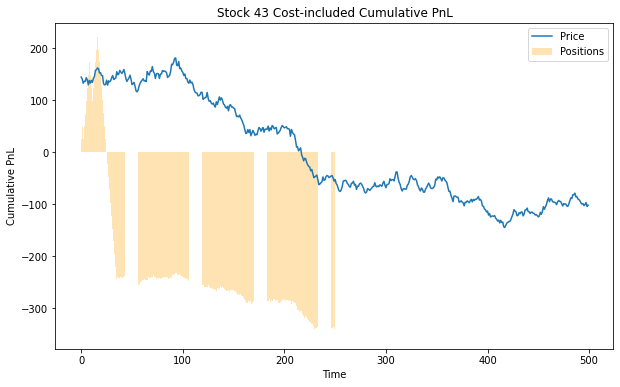

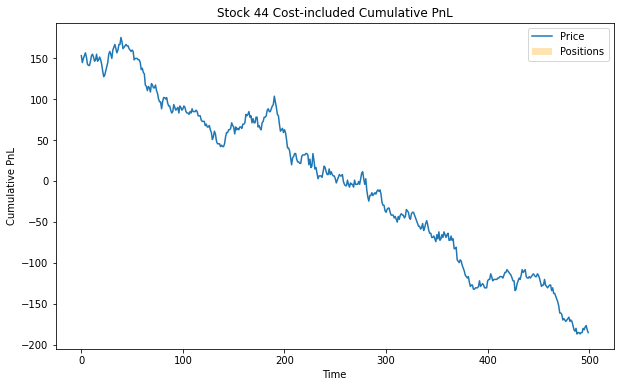

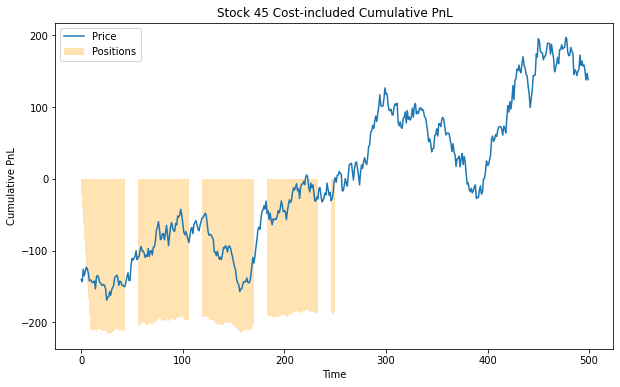

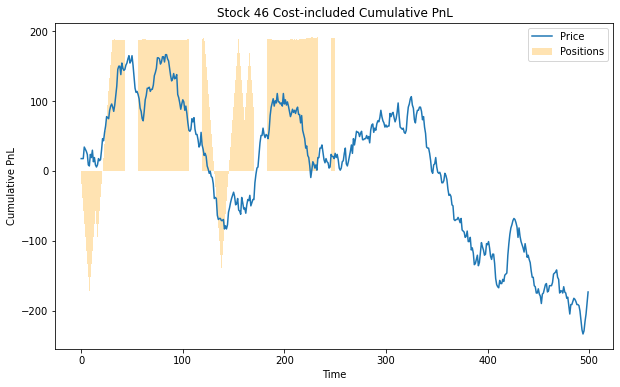

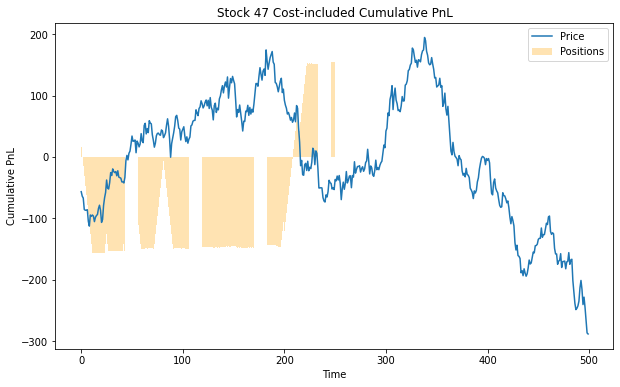

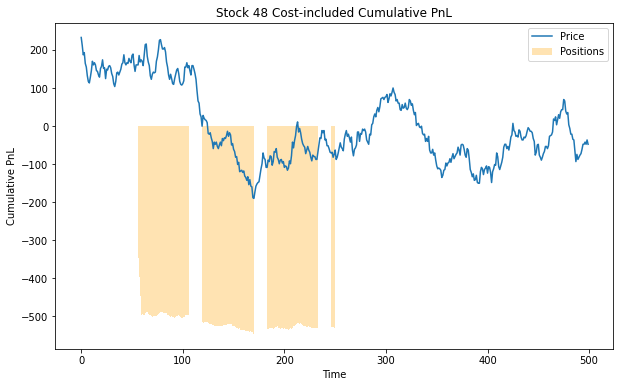

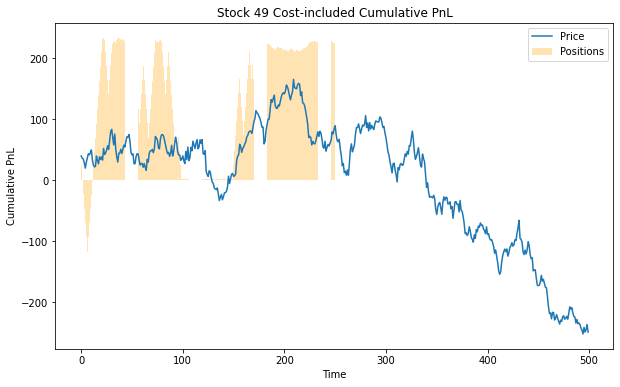

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming todayPL_array and positions are already defined and have appropriate shapes.

for i in range(50):
    plt.figure(figsize=(10, 6))  # Adjust the figure size if necessary
    
    # Plot the cumulative PnL
    plt.plot(100*(prcAll[i, 250:] - np.mean(prcAll[i, 250:]))/np.std(prcAll[i, 250:]), label='Price')
    
    # Add the bar chart at y = 0
    plt.bar(range(250), positions[i, :250], alpha=0.3, label='Positions', color='orange')
    
    # Adding a title and labels
    plt.title(f'Stock {i} Cost-included Cumulative PnL')
    plt.xlabel('Time')
    plt.ylabel('Cumulative PnL')
    
    # Adding a legend
    plt.legend()
    
    # Show the plot
    plt.show()


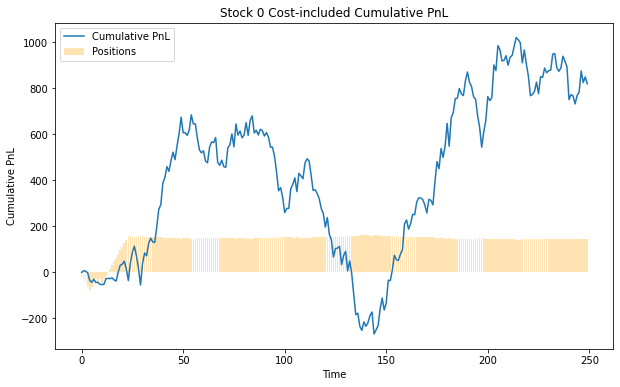

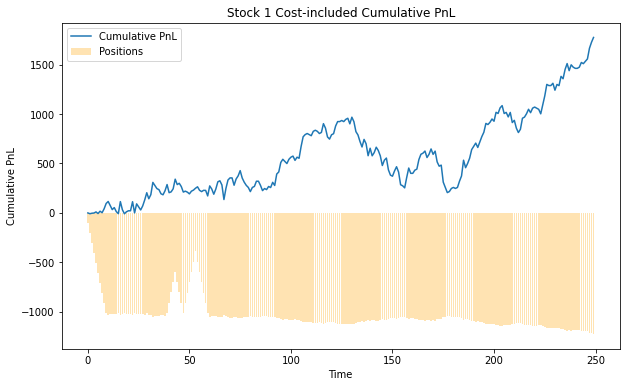

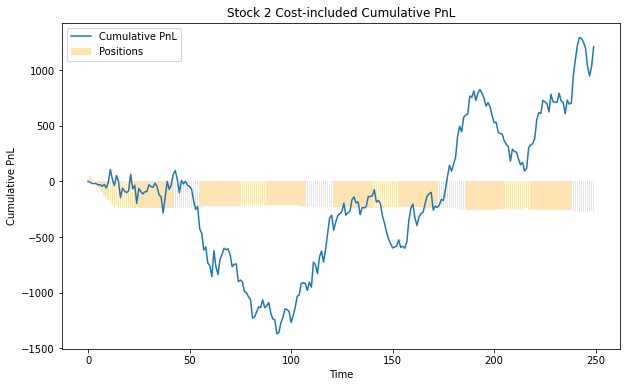

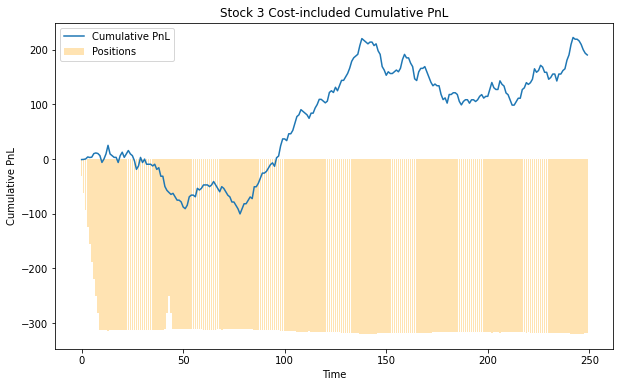

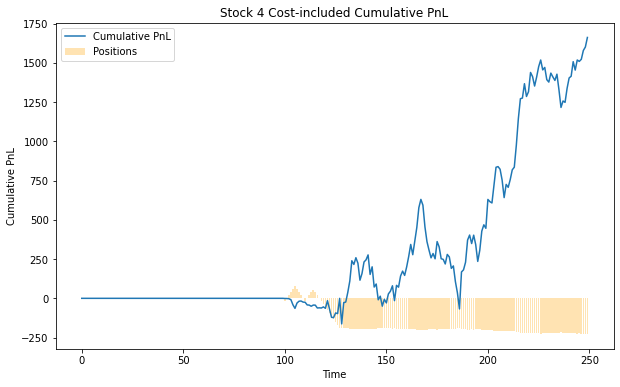

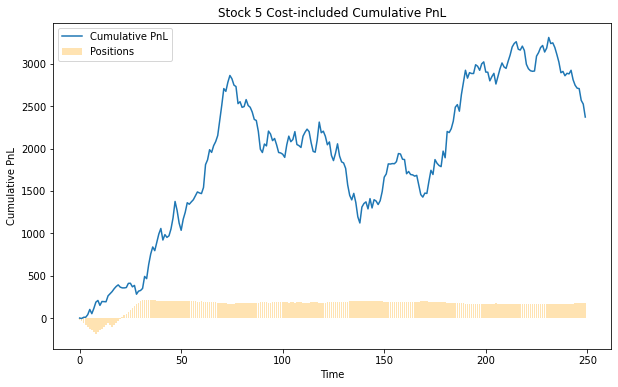

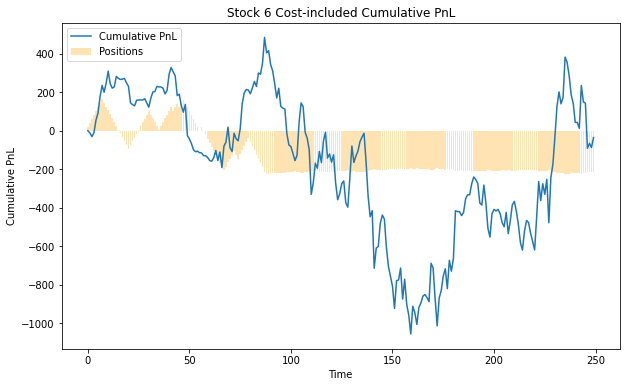

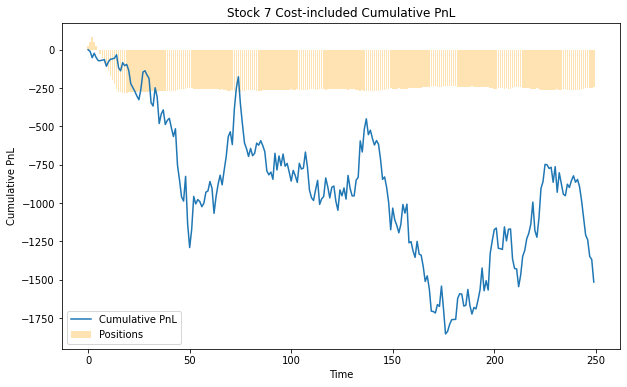

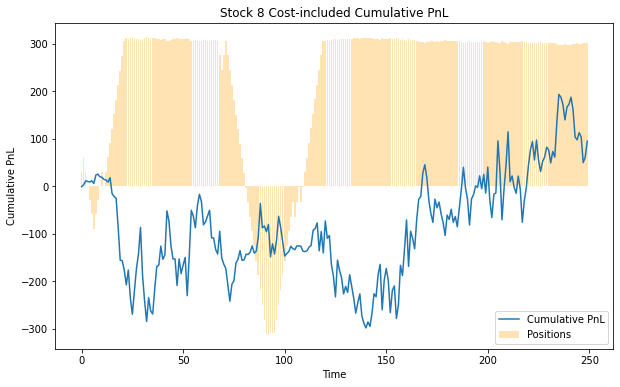

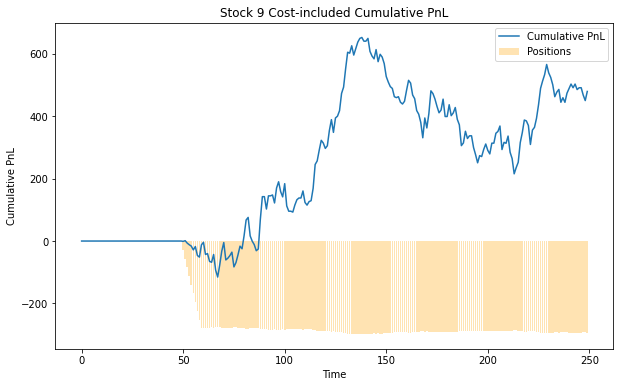

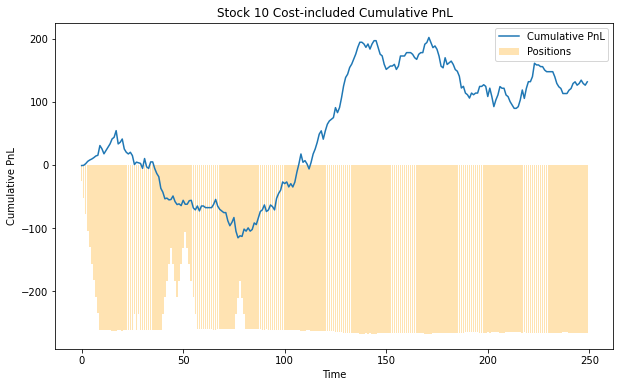

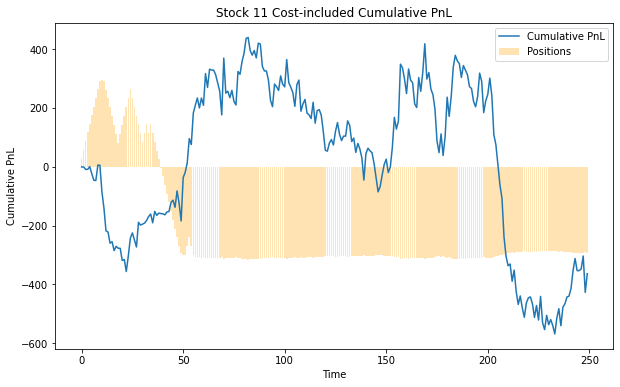

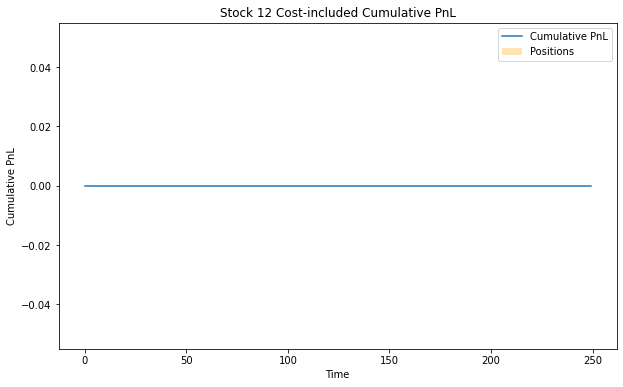

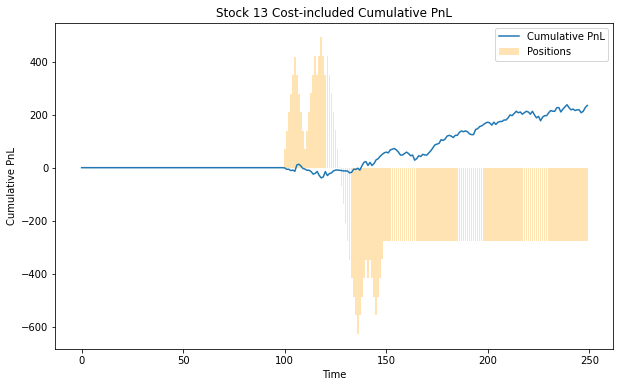

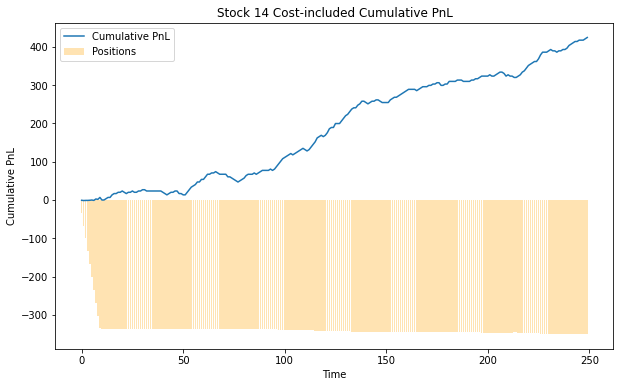

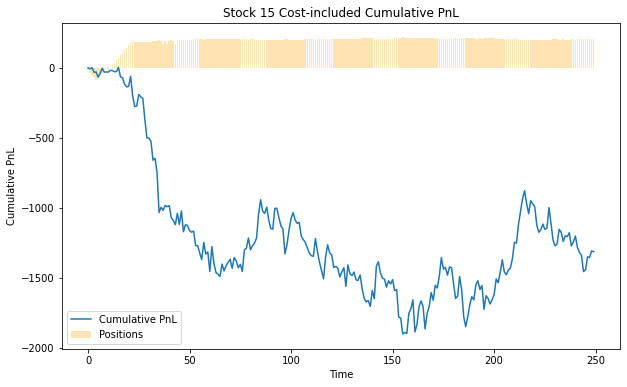

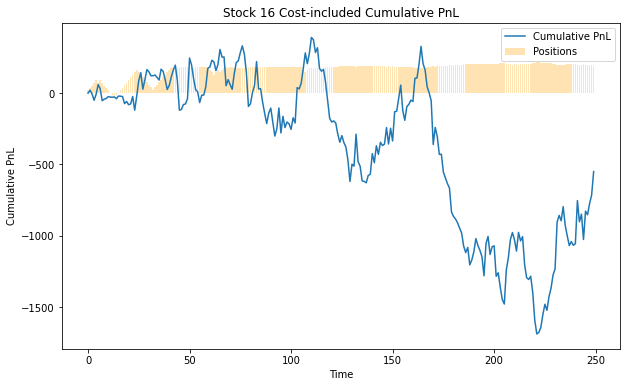

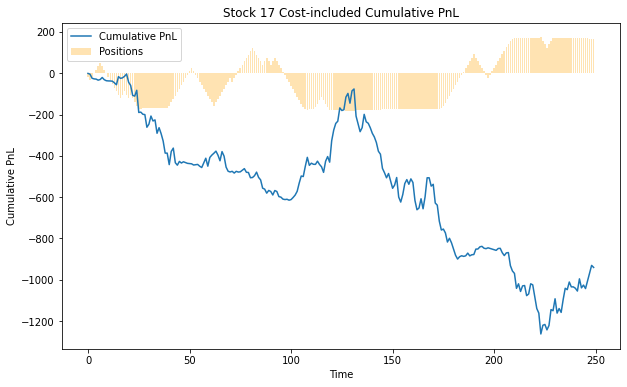

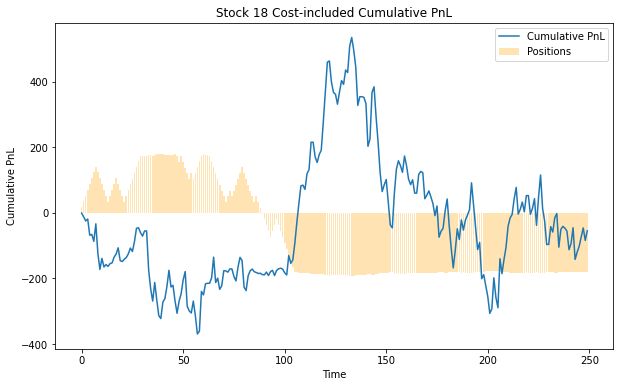

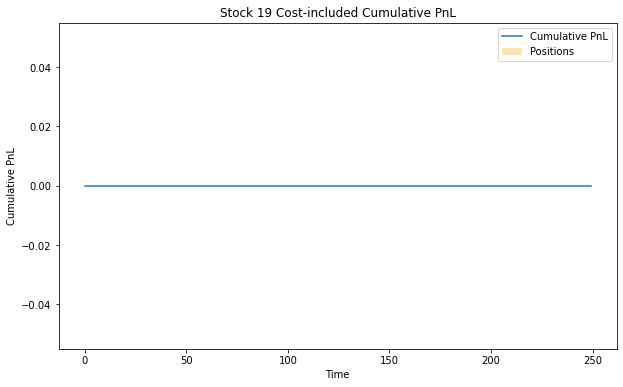

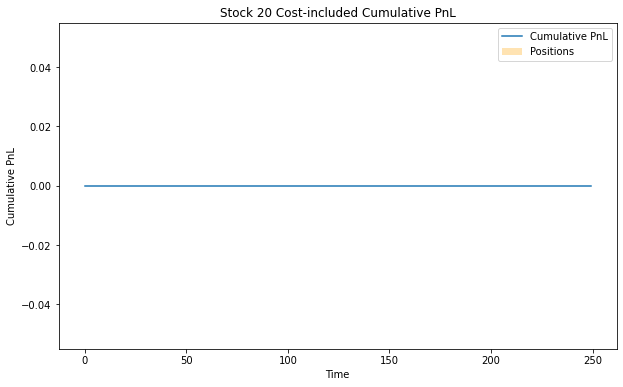

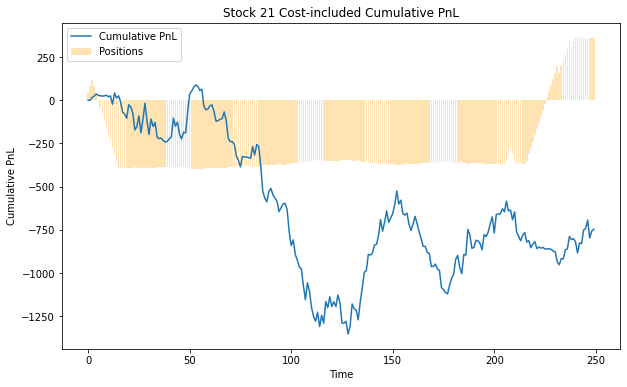

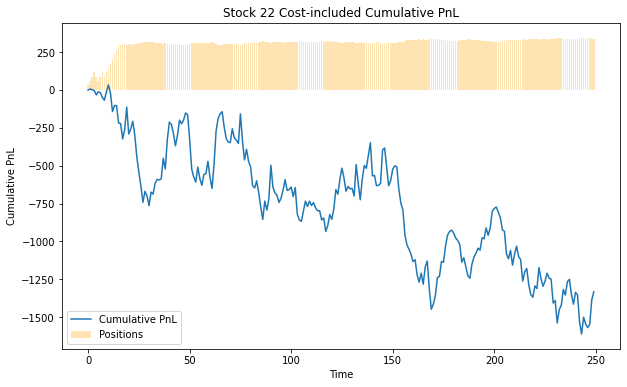

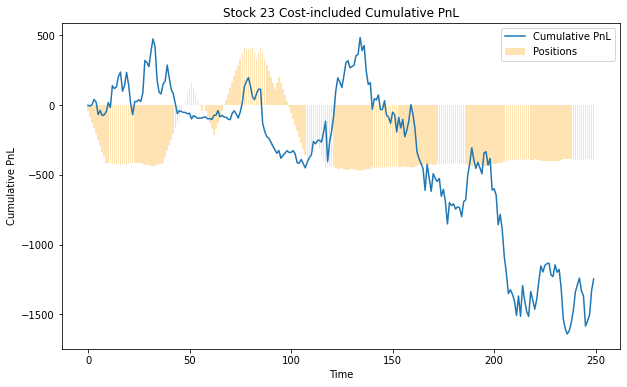

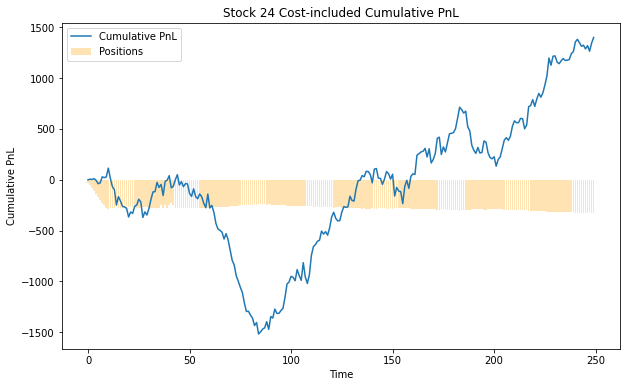

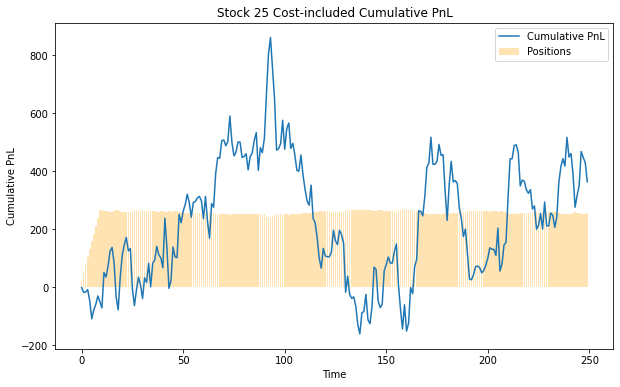

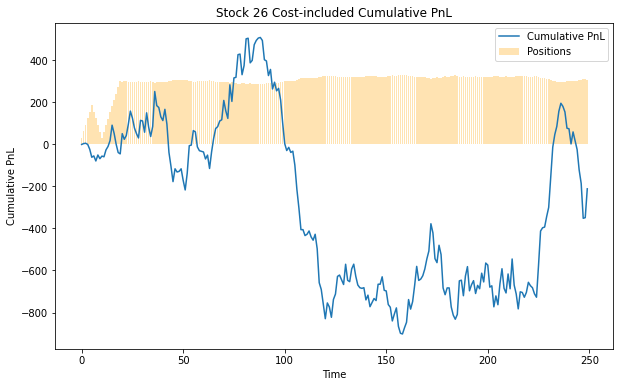

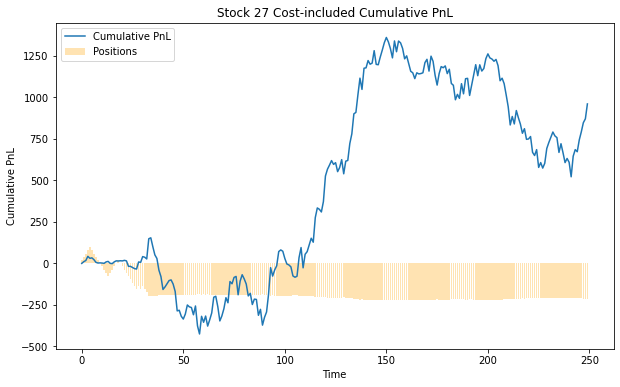

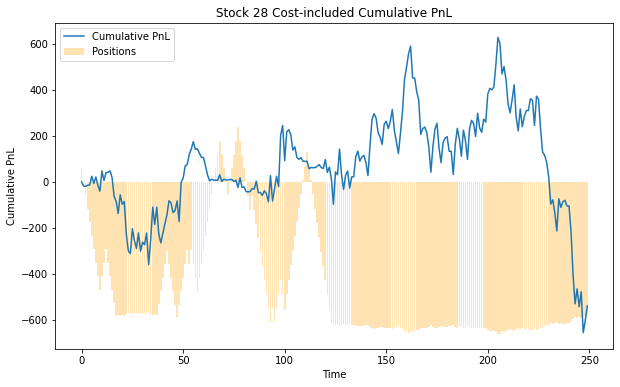

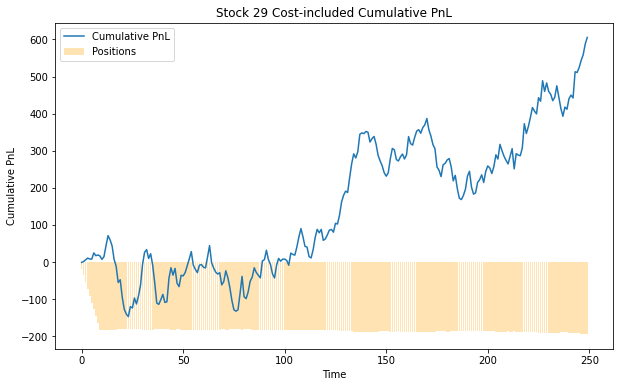

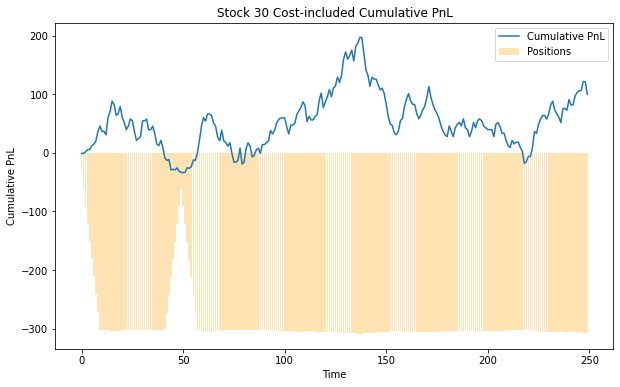

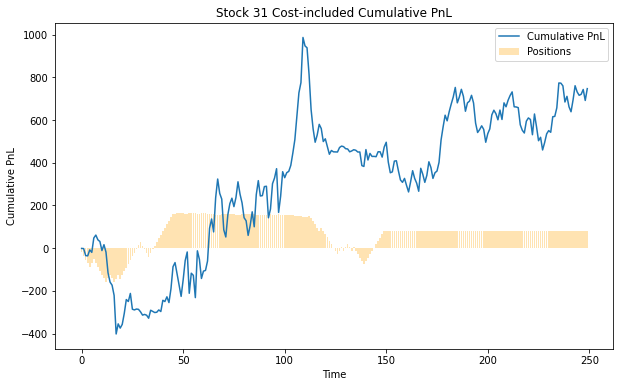

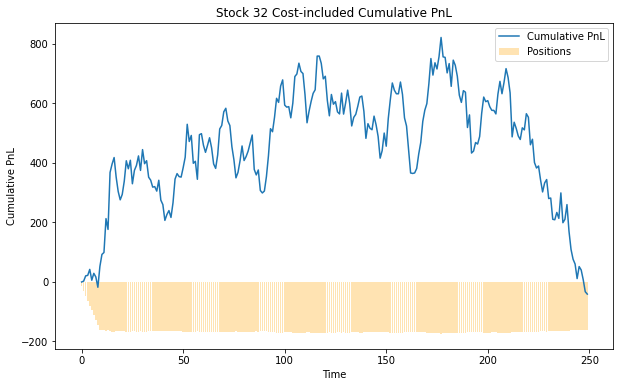

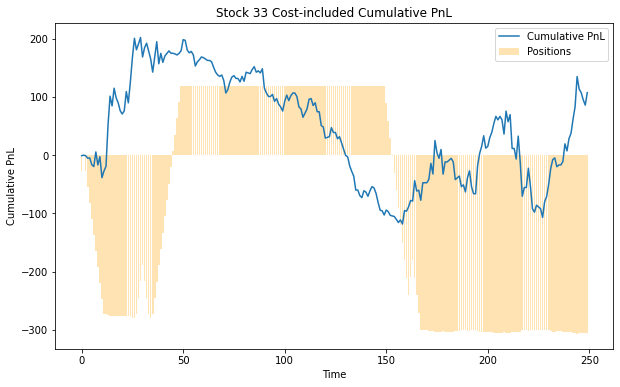

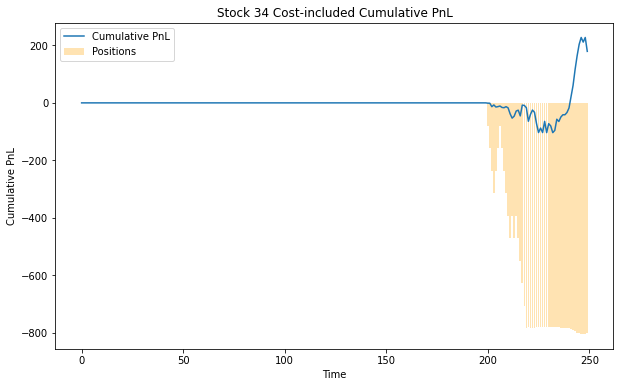

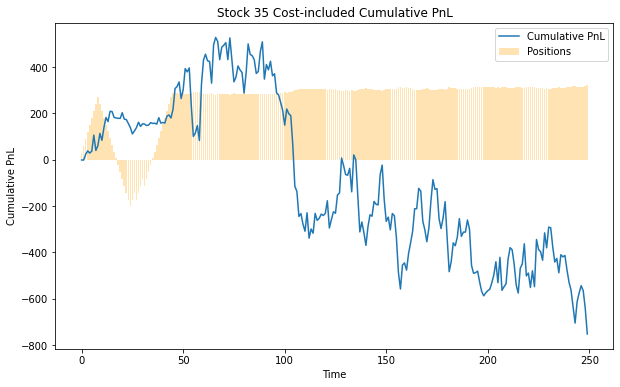

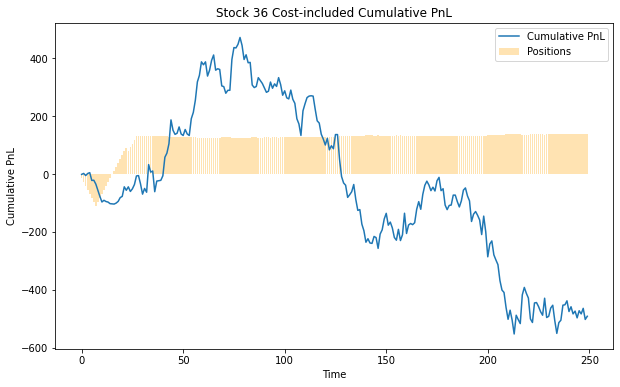

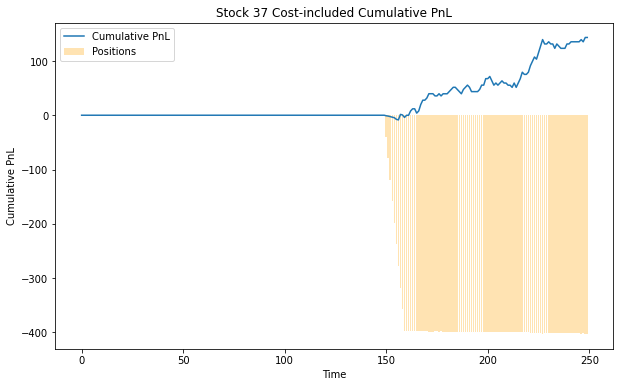

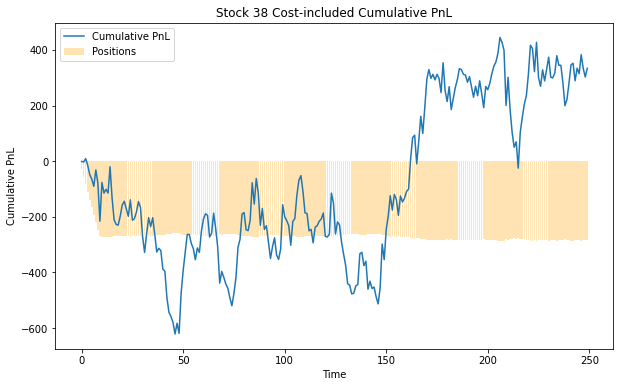

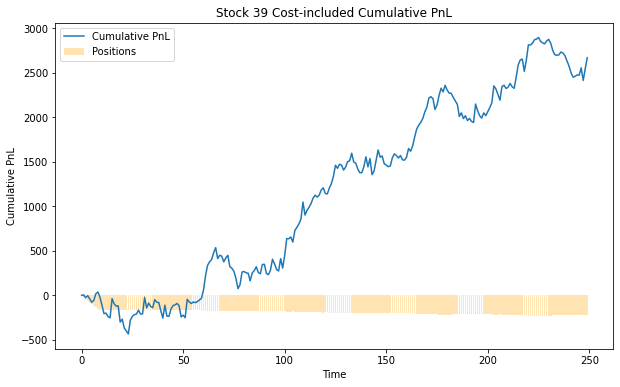

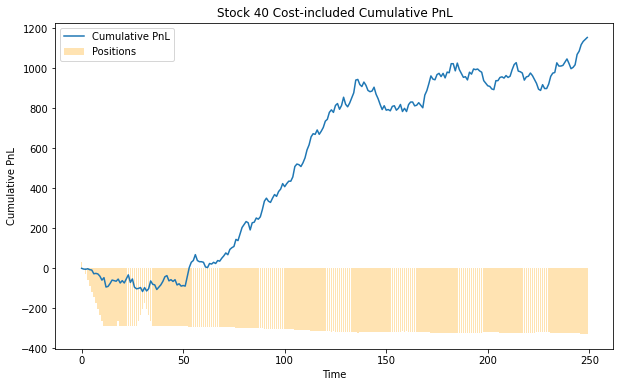

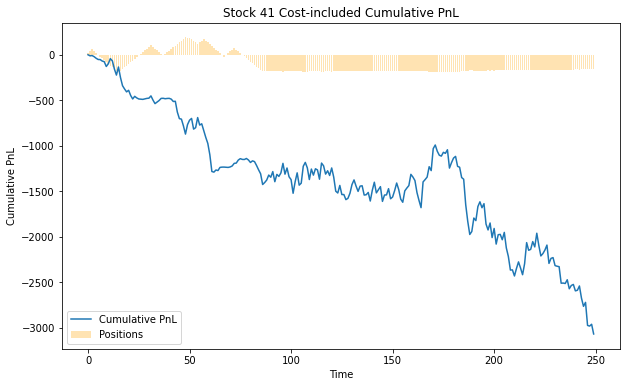

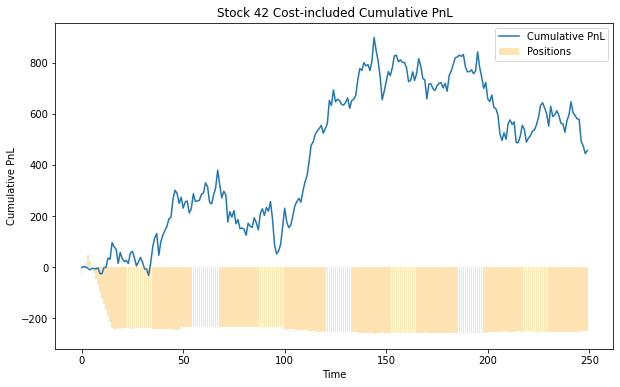

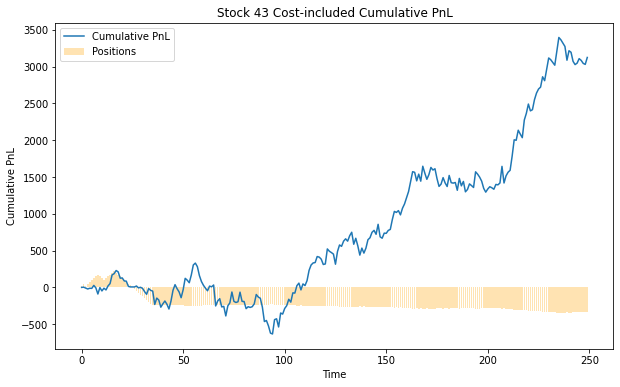

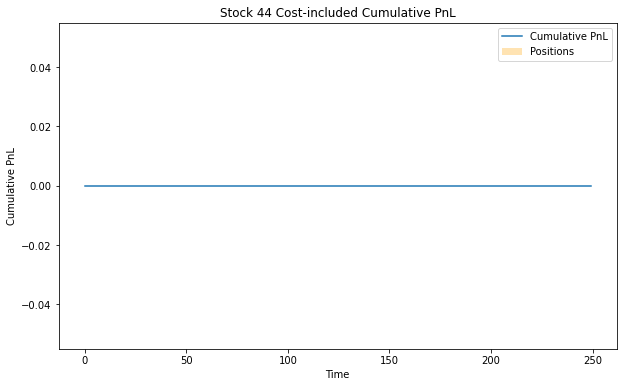

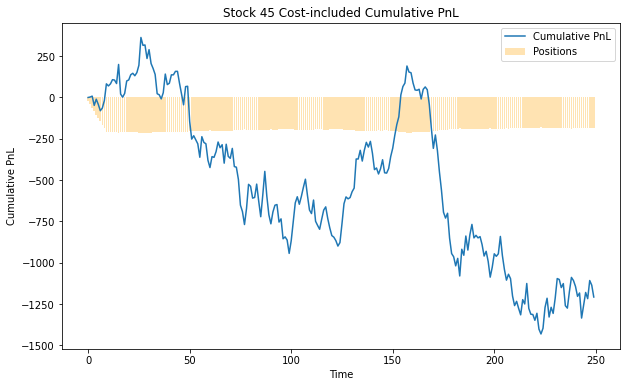

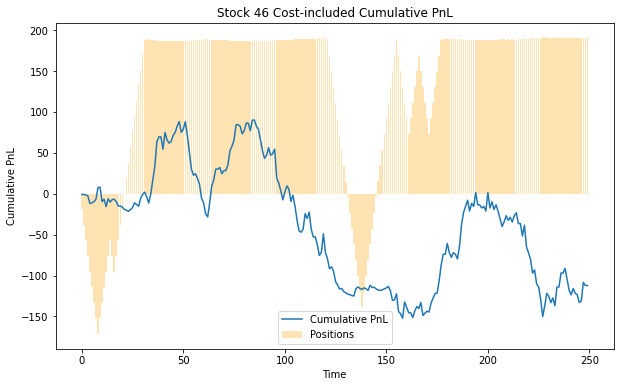

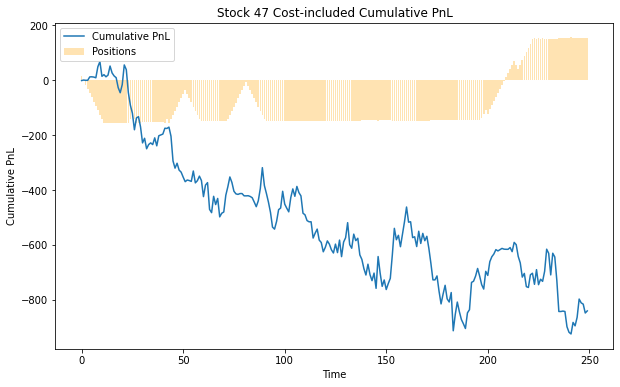

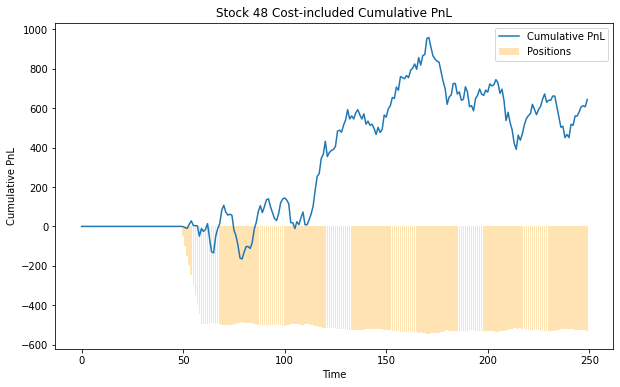

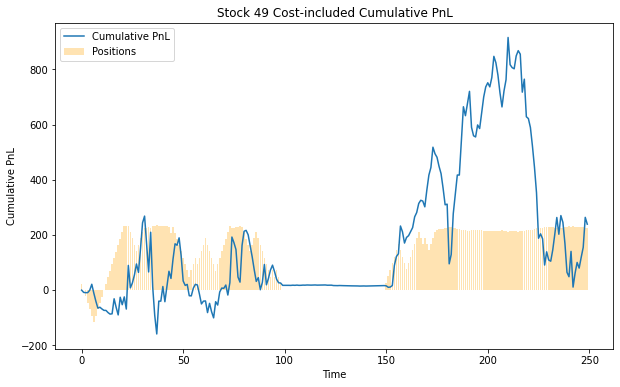

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming todayPL_array and positions are already defined and have appropriate shapes.

for i in range(50):
    plt.figure(figsize=(10, 6))  # Adjust the figure size if necessary
    
    # Plot the cumulative PnL
    plt.plot(np.cumsum(todayPL_array[i, :250]), label='Cumulative PnL')
    
    # Add the bar chart at y = 0
    plt.bar(range(250), positions[i, :250], alpha=0.3, label='Positions', color='orange')
    
    # Adding a title and labels
    plt.title(f'Stock {i} Cost-included Cumulative PnL')
    plt.xlabel('Time')
    plt.ylabel('Cumulative PnL')
    
    # Adding a legend
    plt.legend()
    
    # Show the plot
    plt.show()


# Graveyard